# Tutorial 2: Train a Tiny Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/commanderjcc/torchlingo/blob/main/docs/docs/tutorials/02-train-tiny-model.ipynb)

Build and train your first Transformer model on a small dataset—runs in seconds!

**⚡ Running in Google Colab?** Make sure to:
1. Go to **Runtime → Change runtime type → GPU** (recommended for faster training)
2. Uncomment and run the `%pip install torchlingo` cell below

In [ ]:
# Install TorchLingo (uncomment in Google Colab)
# %pip install torchlingo

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1
CUDA available: False


In [2]:
# Set device (will use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import TorchLingo modules
from pathlib import Path
from torch.utils.data import DataLoader
from torchlingo.config import Config
from torchlingo.data_processing import NMTDataset, collate_fn
from torchlingo.models import SimpleTransformer
from torchlingo.training import train_model
from torchlingo.inference import translate_batch

print("✓ Imports successful!")

Using device: cpu
✓ Imports successful!
✓ Imports successful!


## Part 1: Prepare Data

We'll load the packaged `example.tsv` and take a small sample so training stays quick.

In [ ]:
import pandas as pd

# Load the provided example subset and sample a tiny slice for speed
subset_path = Path("../../../data/example.tsv")
if not subset_path.exists():
    raise FileNotFoundError("data/example.tsv not found. Please download or place it under data/.")

df_full = pd.read_csv(subset_path, sep="\t")
df = df_full.sample(n=2000, random_state=0) if len(df_full) > 2000 else df_full.copy()

# Save the tiny sample
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
train_path = data_dir / "train.tsv"
df.to_csv(train_path, sep="\t", index=False)

print(f"Loaded example subset with {len(df_full)} pairs; sampled {len(df)} for quick training.")

Loaded example subset with 104000 pairs; sampled 2000 for quick training.


In [7]:
# Create dataset
dataset = NMTDataset(train_path)

print(f"Dataset: {len(dataset)} samples")
print(f"Source vocab: {len(dataset.src_vocab)} tokens")
print(f"Target vocab: {len(dataset.tgt_vocab)} tokens")

Dataset: 2000 samples
Source vocab: 2659 tokens
Target vocab: 2795 tokens


## Part 2: Create the Model

We'll create a tiny Transformer that can train in seconds.

In [12]:
# Configuration for a tiny model
config = Config(
    d_model=64,            # Small hidden dimension
    n_heads=4,             # Few attention heads
    num_encoder_layers=2,  # Shallow encoder
    num_decoder_layers=2,  # Shallow decoder
    d_ff=128,              # Small feedforward
    dropout=0.1,
    batch_size=8,
)

# Create model
model = SimpleTransformer(
    src_vocab_size=len(dataset.src_vocab),
    tgt_vocab_size=len(dataset.tgt_vocab),
    config=config,
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {num_params:,} parameters")

Model created with 698,411 parameters


## Part 3: Training Setup

In [13]:
# Create data loader
train_loader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)

print(f"Training setup complete!")
print(f"  Batches per epoch: {len(train_loader)}")

Training setup complete!
  Batches per epoch: 250


## Part 4: Train with the helper

Use TorchLingo's `train_model` helper to handle the training loop, gradient clipping, and optional logging.

In [14]:
# Train using the library helper
num_epochs = 5
print("Training with train_model helper...")
train_result = train_model(
    model,
    train_loader,
    num_epochs=num_epochs,
    device=device,
    config=config,
    gradient_clip=1.0,
    log_every=10 if len(train_loader) > 10 else 0,
)
losses = train_result.train_losses
print(f"\nTraining complete! Final loss: {losses[-1]:.4f}")

Training with train_model helper...
Epoch 1 Step 10/250 | Train Loss: 7.9176
Epoch 1 Step 20/250 | Train Loss: 7.8772
Epoch 1 Step 30/250 | Train Loss: 7.8336
Epoch 1 Step 40/250 | Train Loss: 7.7967
Epoch 1 Step 50/250 | Train Loss: 7.7576
Epoch 1 Step 60/250 | Train Loss: 7.7297
Epoch 1 Step 70/250 | Train Loss: 7.6971
Epoch 1 Step 80/250 | Train Loss: 7.6639
Epoch 1 Step 90/250 | Train Loss: 7.6314
Epoch 1 Step 100/250 | Train Loss: 7.6009
Epoch 1 Step 110/250 | Train Loss: 7.5794
Epoch 1 Step 120/250 | Train Loss: 7.5525
Epoch 1 Step 130/250 | Train Loss: 7.5275
Epoch 1 Step 140/250 | Train Loss: 7.5032
Epoch 1 Step 150/250 | Train Loss: 7.4755
Epoch 1 Step 160/250 | Train Loss: 7.4513
Epoch 1 Step 170/250 | Train Loss: 7.4278
Epoch 1 Step 180/250 | Train Loss: 7.4059
Epoch 1 Step 190/250 | Train Loss: 7.3828
Epoch 1 Step 200/250 | Train Loss: 7.3595
Epoch 1 Step 210/250 | Train Loss: 7.3379
Epoch 1 Step 220/250 | Train Loss: 7.3149
Epoch 1 Step 230/250 | Train Loss: 7.2922
Epoch 1

In [15]:
# Quick look at losses
print(f"Epochs run: {len(losses)}")
print(f"First 3 losses: {[round(l, 4) for l in losses[:3]]}")
print(f"Final loss: {losses[-1]:.4f}")

Epochs run: 5
First 3 losses: [7.2449, 6.2243, 5.7984]
Final loss: 5.6876


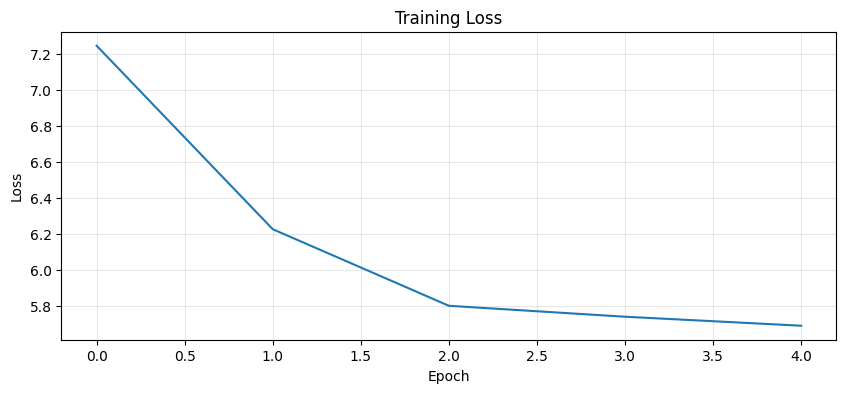

In [16]:
# Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True, alpha=0.3)
plt.show()

## Part 5: Quick Test

Let's see if our model learned anything!

In [17]:
# Simple translation helper using the library inference util

def translate(sentences):
    return translate_batch(
        model,
        sentences,
        dataset.src_vocab,
        dataset.tgt_vocab,
        decode_strategy="greedy",
        device=device,
    )

In [24]:
# Test on training examples
test_sentences = [
    "Hello World",
    "Good morning",
    "Thank you",
    "I love you",
]

print("Testing on training examples:")
print("-" * 50)
translations = translate(test_sentences)
for src, translation in zip(test_sentences, translations):
    print(f"{src:20} → {translation}")

Testing on training examples:
--------------------------------------------------
Hello World          → 
Good morning         → 
Thank you            → 
I love you           → 


## Part 6: Save the Model

In [19]:
# Create checkpoints directory
ckpt_dir = Path("checkpoints")
ckpt_dir.mkdir(exist_ok=True)

# Save everything needed for inference
checkpoint = {
    'model_state_dict': model.state_dict(),
    'src_vocab': dataset.src_vocab,
    'tgt_vocab': dataset.tgt_vocab,
    'config': {
        'd_model': config.d_model,
        'n_heads': config.n_heads,
        'num_encoder_layers': config.num_encoder_layers,
        'num_decoder_layers': config.num_decoder_layers,
        'd_ff': config.d_ff,
    },
}

ckpt_path = ckpt_dir / "tiny_model.pt"
torch.save(checkpoint, ckpt_path)
print(f"Model saved to {ckpt_path}")

Model saved to checkpoints/tiny_model.pt


In [20]:
# Demo: Load and use the saved model
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)

loaded_model = SimpleTransformer(
    src_vocab_size=len(checkpoint['src_vocab']),
    tgt_vocab_size=len(checkpoint['tgt_vocab']),
    **checkpoint['config'],
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Test loaded model
translation = greedy_decode(
    loaded_model, "Hello world",
    checkpoint['src_vocab'], checkpoint['tgt_vocab'],
    device
)
print(f"Loaded model test: 'Hello world' → '{translation}'")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchlingo.data_processing.vocab.Vocab was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torchlingo.data_processing.vocab.Vocab])` or the `torch.serialization.safe_globals([torchlingo.data_processing.vocab.Vocab])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## Summary

You've learned:

1. **Model creation**: Configure and instantiate `SimpleTransformer`
2. **Training loop**: Forward pass, loss, backward pass, optimizer step
3. **Teacher forcing**: Feed correct tokens during training
4. **Greedy decoding**: Generate translations token by token
5. **Checkpointing**: Save and load models

## Next Steps

Continue to [Tutorial 3: Inference and Beam Search](03-inference-and-beamsearch.ipynb) to learn better decoding strategies!